<a href="https://colab.research.google.com/github/shayari21/100DaysOfML/blob/master/Task%2003/WIP.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML in Cybersecurity: Task 3

## Team
  * **Team name**: ESS
  * **Members**: Eiram Mahera Sheikh (eish00001@stud.uni-saarland.de), Shravan Swaminathan(shsw00001@stud.uni-saarland.de), Shayari Bhattacharjee(shbh00002@stud.uni-saarland.de)


## Logistics
  * **Due date**: 9th December 2021, 23:59:59
  * Email the completed notebook to: `mlcysec_ws2022_staff@lists.cispa.saarland`
  * Complete this in **teams of 3**
  * Feel free to use the forum to discuss.
  
## Timeline
  * 26-Nov-2021: hand-out
  * **09-Dec-2021**: Email completed notebook
  
  
## About this Project
In this project, you will explore an application of ML to a popular task in cybersecurity: malware classification.
You will be presented with precomputed behaviour analysis reports of thousands of program binaries, many of which are malwares.
Your goal is to train a malware detector using this behavioural reports.


## A Note on Grading
The grading for this project will depend on:
 1. Vectorizing Inputs
   * Obtaining a reasonable vectorized representations of the input data (a file containing a sequence of system calls)
   * Understanding the influence these representations have on your model
 1. Classification Model  
   * Following a clear ML pipeline
   * Obtaining reasonable performances (>60\%) on held-out test set
   * Choice of evaluation metric
   * Visualizing loss/accuracy curves
 1. Analysis
   * Which methods (input representations/ML models) work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
   * Anything else you find interesting (this part is open-ended)


## Grading Details
 * 40 points: Vectorizing input data (each input = behaviour analysis file in our case)
 * 40 points: Training a classification model
 * 15 points: Analysis/Discussion
 * 5 points: Clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your project report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use the final summary to provide a report about these.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.1: Updated deadline
  * v1.0: Initial notebook
  
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 
import pathlib
from pathlib import Path

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from keras.preprocessing.text import text_to_word_sequence
from nltk import ngrams

# Setup

  * Download the datasets: [train](https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm) (128M) and [test](https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE) (92M)
  * Unpack them under `./data/train` and `./data/test`
  * Hint: you can execute shell scripts from notebooks using the `!` prefix, e.g., `! wget <url>`

In [3]:
# We have stored the data on google drive for persistence.
# Mount the drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
train_path = "drive/MyDrive/data/data/train"
test_path = "drive/MyDrive/data/data/test"

In [5]:
# Check that you are prepared with the data
! printf '# train examples (Should be 13682) : '; ls {train_path} | wc -l
! printf '# test  examples (Should be 10000) : '; ls {test_path} | wc -l

# train examples (Should be 13682) : 13692
# test  examples (Should be 10000) : 10020


Now that you're set, let's briefly look at the data you have been handed.
Each file encodes the behavior report of a program (potentially a malware), using an encoding scheme called "The Malware Instruction Set" (MIST for short).
At this point, we highly recommend you briefly read-up Sec. 2 of the [MIST](http://www.mlsec.org/malheur/docs/mist-tr.pdf) documentation.

You will find each file named as `filename.<malwarename>`:
```
» ls data/train | head
00005ecc06ae3e489042e979717bb1455f17ac9d.NothingFound
0008e3d188483aeae0de62d8d3a1479bd63ed8c9.Basun
000d2eea77ee037b7ef99586eb2f1433991baca9.Patched
000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
0010f78d3ffee61101068a0722e09a98959a5f2c.Basun
0013cd0a8febd88bfc4333e20486bd1a9816fcbf.Basun
0014aca72eb88a7f20fce5a4e000c1f7fff4958a.Texel
001ffc75f24a0ae63a7033a01b8152ba371f6154.Texel
0022d6ba67d556b931e3ab26abcd7490393703c4.Basun
0028c307a125cf0fdc97d7a1ffce118c6e560a70.Swizzor
...
```
and within each file, you will see a sequence of individual systems calls monitored duing the run-time of the binary - a malware named 'Basun' in the case:
```
» head data/train/000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
# process 000006c8 0000066a 022c82f4 00000000 thread 0001 #
02 01 | 000006c8 0000066a 00015000
02 02 | 00006b2c 047c8042 000b9000
02 02 | 00006b2c 047c8042 00108000
02 02 | 00006b2c 047c8042 00153000
02 02 | 00006b2c 047c8042 00091000
02 02 | 00006b2c 047c8042 00049000
02 02 | 00006b2c 047c8042 000aa000
02 02 | 00006b2c 047c8042 00092000
02 02 | 00006b2c 047c8042 00011000
...
```
(**Note**: Please ignore the first line that begins with `# process ...`.)

Your task in this project is to train a malware detector, which given the sequence of system calls (in the MIST-formatted file like above), predicts one of 10 classes: `{ Agent, Allaple, AutoIt, Basun, NothingFound, Patched, Swizzor, Texel, VB, Virut }`, where `NothingFound` roughly represents no malware is present.
In terms of machine learning terminology, your malware detector $F: X \rightarrow Y$ should learn a mapping from the MIST-encoded behaviour report (the input $x \in X$) to the malware class $y \in Y$.

Consequently, you will primarily tackle two challenges in this project:
  1. "Vectorizing" the input data i.e., representing each input (file) as a tensor
  1. Training an ML model
  

### Some tips:
  * Begin with an extremely simple representation/ML model and get above chance-level classification performance
  * Choose your evaluation metric wisely
  * Save intermediate computations (e.g., a token to index mapping). This will avoid you parsing the entire dataset for every experiment
  * Try using `multiprocessing.Pool` to parallelize your `for` loops

---

# 1. Vectorize Data

## 1.a. Load Raw Data

In [6]:
def load_content(filepath):
    '''Given a filepath, returns (content, classname), where content = [list of lines in file]'''
    label = filepath.split('.')[-1]
    
    # open the file within a context manager and read all the lines
    with open(filepath, "r") as fh:
      lines = fh.readlines()
    
    return lines, label


def load_data(data_path, nworkers=10):
    '''Returns each data sample as a tuple (x, y), x = sequence of strings (i.e., syscalls), y = malware program class'''
    raw_data_samples = []
    
    # get a list of all files in the training data
    files = os.listdir(data_path)

    # load the content of each file
    for file in tqdm(files):
        lines, label = load_content(os.path.join(data_path, file))
        raw_data_samples.append((lines, label))

        # remove these 2 lines for final execution on entire dataset
        if len(raw_data_samples)==200:
            break

    return raw_data_samples

In [7]:
print('=> Loading training data ... ')
train_raw_samples = load_data(Path(train_path))

=> Loading training data ... 


  1%|▏         | 199/13692 [00:28<32:34,  6.91it/s]


In [8]:
project_mode = 'trainval'    # trainval, traintest, debug
np.random.seed(123)          # To perform the same split across multiple runs

if project_mode == 'trainval':
    # Split data into train and validation set
    train_size = int(len(train_raw_samples) * 0.8)
    np.random.shuffle(train_raw_samples)
    train_raw_samples, test_raw_samples = train_raw_samples[:train_size], train_raw_samples[train_size:]

elif project_mode == 'traintest':
    # Load train and test data
    test_raw_samples = load_data(Path(test_path))

elif project_mode == 'debug':
    np.random.shuffle(train_raw_samples)
    train_raw_samples, test_raw_samples = train_raw_samples[:1000], train_raw_samples[1001:1250]

else:
    raise ValueError('Unrecognized mode')
    
print('=> # Train samples = ', len(train_raw_samples))
print('=> # Test  samples = ', len(test_raw_samples))

=> # Train samples =  160
=> # Test  samples =  40


## 1.b. Vectorize: Setup

Make one pass over the inputs to identify relevant features/tokens.

Suggestion:
  - identify tokens (e.g., unigrams, bigrams)
  - create a token -> index (int) mapping. Note that you might have a >10K unique tokens. So, you will have to choose a suitable "vocabulary" size.

In [9]:
class_to_idx = {
    'Agent':0, 
    'Allaple':1, 
    'AutoIt':2, 
    'Basun':3, 
    'NothingFound':4, 
    'Patched':5, 
    'Swizzor':6, 
    'Texel':7, 
    'VB':8, 
    'Virut':9
    }

   
def get_key_idx_map(counter, vocab_size, ukn_token='_ukn_'):
    # counter is a mapping: token -> count
    # build vectorizer using vocab_size most common elements
    key_to_idx, idx_to_key = dict(), dict()
    word_count = list(counter.most_common(vocab_size))
    counter = 0
    
    for word, count in word_count:
        key_to_idx[word] = counter
        idx_to_key[counter] = word
        counter += 1

    return key_to_idx, idx_to_key


def helper1_tokenize(raw_data):
    tokenized_data = []
    for content, label in raw_data:
        tokens = []
        for line in content[1: -1]:
            tokens.extend(text_to_word_sequence(line))
        tokenized_data.append(tokens)

    return tokenized_data


def helper2_ngrams(tokens, n):
    n_grams = []
    for token_set in tokens:
        n_grams.append(list(ngrams(token_set, n)))

    return n_grams


def helper3_get_class_to_idx_map(raw_data):
    labels_y = list()
    for counter, labels in raw_data:
        labels_y.append(class_to_idx[labels])

    return np.array(labels_y)


In [10]:
tokens = helper1_tokenize(train_raw_samples)

#unigrams = helper2_ngrams(tokens, 1)
bigrams = helper2_ngrams(tokens, 2)
#trigrams = helper2_ngrams(tokens, 3)

tokens = []

MAX_VOCAB_SIZE = 300

ngram_tokens = []
for ngram_set in bigrams:
    ngram_tokens.extend(ngram_set)

token_to_idx, idx_to_token = get_key_idx_map(Counter(ngram_tokens), MAX_VOCAB_SIZE)
ngram_tokens = []
train_y = helper3_get_class_to_idx_map(train_raw_samples)
test_y = helper3_get_class_to_idx_map(test_raw_samples)

# Save vocab to file
out_path = 'application_vocab_{}.pkl'.format(MAX_VOCAB_SIZE)
with open(out_path, 'wb') as wf:
    dct = {
        'token_to_idx': token_to_idx,
        'idx_to_token': idx_to_token
        }
    pickle.dump(dct, wf)



## 1.c. Vectorize Data

Use the (token $\rightarrow$ index) mapping you created before to vectorize your data

In [11]:
def BinaryVectorizer(tokens):
    vectorized = []

    for token in tokens:
        vector = np.zeros(MAX_VOCAB_SIZE)
        for word in token:
            if word in token_to_idx:
                vector[token_to_idx[word]] = 1
        vectorized.append(np.array(vector, dtype='float32'))

    return np.array(vectorized, dtype='float32')


def CountVectorizer(ngrams):
    vectorized = []

    for ng in ngrams:
        vector = np.zeros(MAX_VOCAB_SIZE)
        token_counter = dict(Counter(ng))
        unique_tokens = list(token_counter.keys())
        for token in unique_tokens:
            if token in token_to_idx:
                vector[token_to_idx[token]] = token_counter[token]
        vectorized.append(np.array(vector, dtype='float32'))

    return np.array(vectorized, dtype='float32')

In [12]:
def vectorize_raw_samples(raw_samples, nworkers=10):
    vectorized_samples = []
    
    tokens = helper1_tokenize(raw_samples)
    ngram_data = helper2_ngrams(tokens, 2)
    vectorized_samples = BinaryVectorizer(ngram_data)

    return vectorized_samples

In [13]:
print('=> Processing: Train')
train_data = vectorize_raw_samples(train_raw_samples)
print()
print('=> Processing: Test')
test_data = vectorize_raw_samples(test_raw_samples)

=> Processing: Train

=> Processing: Test


In [14]:
train_x = torch.from_numpy(train_data).float()
test_x = torch.from_numpy(test_data).float()

train_y = torch.tensor(train_y, dtype=torch.long)
test_y = torch.tensor(test_y, dtype=torch.long)

trainset = TensorDataset(train_x, train_y)
testset = TensorDataset(test_x, test_y)

torch.save(trainset, 'trainset.pt')
torch.save(testset, 'testset.pt')

# 2. Train Model

You will now train an ML model on the vectorized datasets you created previously.

_Note_: Although we often refer to each input as a 'vector' for simplicity, each of your inputs can also be higher dimensional tensors.

## 2.a. Helpers

In [15]:
def evaluate_preds(y_true, y_predicted):
    precision = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
    recall = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
    positive = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
    true_positive = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
    f1 = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0} 
    classes = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
    
    true_samples = generate_true_labels(y_true)
    for out_idx in range(len(y_predicted)):
        for inner_idx in range(len(y_predicted[out_idx])):
            if y_predicted[out_idx][inner_idx] == y_true[out_idx][inner_idx]:
                true_positive[y_predicted[out_idx][inner_idx]] += 1
            positive[y_predicted[out_idx][inner_idx]] += 1
            classes[y_predicted[out_idx][inner_idx]] += 1
    
    for key, vals in classes.items():
        if positive[key] <= 0.0:
            precision[key] = 0.0
        else:
            precision[key] = (true_positive[key]/positive[key]) * 100
        if true_samples[key] <= 0.0:
            recall[key] = 0.0
        else:
            recall[key] = (true_positive[key]/true_samples[key]) * 100
    
    for key, vals in classes.items():
        if recall[key] <= 0.0:
            f1_scores[key] = 0.0
        else:
            f1_scores[key] = 2*((precision[key]*recall[key])/(precision[key]+recall[key]))
    return precision, recall, f1
    pass


def generate_true_labels(y_true):
    true_labels = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
    for labels in y_true:
        for val in labels:
            true_labels[val] += 1
    return true_labels

def visualize_evaluation(classes, precision, recall, f1):
    data = {'Labels/Malwares': list(classes.keys()), 'Precision': list(precision.values()), 'Recall': list(recall.values()), 'F1 Score': list(f1.values())}
    dataframe = pandas.DataFrame(data=data)
    print(dataframe)


def save_model(model, path):
    checkpoint = {'epoch': epoch,'state_dict': model.state_dict(),'optimizer' : optimizer.state_dict(),'loss': loss_function}
    torch.save(checkpoint, path)
    pass


def save_data(eval_data, path):
    with open(path, 'wb') as wf:
        pickle.dump(eval_data, wf)


## 2.b. Define Model

Describe your model here.

In [19]:
class NetTemplate1(nn.Module):
    def __init__(self, input_dim, h1, h2, h3, output_dim):
        super(NetTemplate1, self).__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, output_dim)

    def forward(self, x):
        # Forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x)

class NetTemplate2(nn.Module):
    def __init__(self):
        super(NetTemplate2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

## 2.c. Set Hyperparameters

In [40]:
# Define your hyperparameters here

in_dims = trainset[0][0].shape[0]
out_dims = len(class_to_idx)
h1, h2, h3 = 128, 128, 64
out_dims = len(class_to_idx)

# Optimization
n_epochs = 30
batch_size=16
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

## 2.d. Train your Model

In [41]:
network1 = NetTemplate1(in_dims, h1, h2, h3, out_dims)
network2 = NetTemplate2()

optimizer1 = optim.SGD(network1.parameters(), lr=learning_rate,momentum=momentum)
optimizer2 = optim.SGD(network2.parameters(), lr=learning_rate,momentum=momentum)

train_loader = DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = testset, batch_size=batch_size, shuffle=False)


In [56]:
predictions_1 = []
targets_1 = []
accuracies_1=[]
train_losses_1 = []
train_counter_1 = []
test_losses_1 = []
test_counter_1 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train1(epoch):
  network1.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.view(-1, in_dims)
    optimizer1.zero_grad()
    output = network1(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer1.step()
    if batch_idx % log_interval == 0:
      print('MLP Network: Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses_1.append(loss.item())
      train_counter_1.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      

def test1():
  network1.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network1(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      predictions_1.append(pred.data.to('cpu').numpy())
      targets_1.append(target.data.to('cpu').numpy())
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  accuracies_1.append(100 * (correct / len(test_loader.dataset)))
  test_losses_1.append(test_loss)
  print('\n MLP Network: Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [57]:
predictions_2 = []
targets_2 = []
accuracies_2=[]
train_losses_2 = []
train_counter_2 = []
test_losses_2 = []
test_counter_2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train2(epoch):
  network2.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.view(-1, in_dims)
    optimizer2.zero_grad()
    output = network1(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer2.step()
    if batch_idx % log_interval == 0:
      print('CNN Network: Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses_2.append(loss.item())
      train_counter_2.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      

def test2():
  network2.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network2(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      predictions_2.append(pred.data.to('cpu').numpy())
      targets_2.append(target.data.to('cpu').numpy())
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  accuracies_2.append(100 * (correct / len(test_loader.dataset)))
  test_losses_2.append(test_loss)
  print('\n CNN Network: Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [58]:
for epoch in range(1, n_epochs+1):
    train1(epoch)
    test1()
    train2(epoch)
    test2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


MLP Network: Train Epoch: 1 [0/160 (0%)]	Loss: 0.672111

 MLP Network: Test set: Avg. loss: 0.7946, Accuracy: 30/40 (75%)

CNN Network: Train Epoch: 1 [0/160 (0%)]	Loss: 0.529448
MLP Network: Train Epoch: 2 [0/160 (0%)]	Loss: 0.581848

 MLP Network: Test set: Avg. loss: 0.8179, Accuracy: 27/40 (68%)

CNN Network: Train Epoch: 2 [0/160 (0%)]	Loss: 0.394880
MLP Network: Train Epoch: 3 [0/160 (0%)]	Loss: 0.950236

 MLP Network: Test set: Avg. loss: 0.7598, Accuracy: 31/40 (78%)

CNN Network: Train Epoch: 3 [0/160 (0%)]	Loss: 0.489193
MLP Network: Train Epoch: 4 [0/160 (0%)]	Loss: 0.477034

 MLP Network: Test set: Avg. loss: 0.8236, Accuracy: 30/40 (75%)

CNN Network: Train Epoch: 4 [0/160 (0%)]	Loss: 0.353329
MLP Network: Train Epoch: 5 [0/160 (0%)]	Loss: 0.521022

 MLP Network: Test set: Avg. loss: 0.7796, Accuracy: 28/40 (70%)

CNN Network: Train Epoch: 5 [0/160 (0%)]	Loss: 0.672579
MLP Network: Train Epoch: 6 [0/160 (0%)]	Loss: 0.917873

 MLP Network: Test set: Avg. loss: 0.7532, Accur

## 2.e. Evaluate model

ValueError: ignored

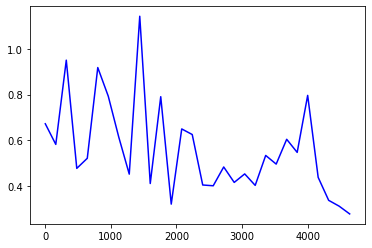

In [59]:
plt.plot(train_counter_1, train_losses_1, color='blue')
plt.plot(len(test_losses_1), test_losses_1, color='red')
plt.legend(['Loss Per Epoch - Optimizer (SGD),', 'Test Loss'], loc='upper right')
plt.xlabel('#Training Data Processed')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

precision_1, recall_1, f1_scores_1 = evaluate_preds(predictions_1, targets_1)
visualize_evaluation(class_to_idx, precision_1, recall_1, f1_scores_1)

In [ ]:
plt.plot(train_counter_2, train_losses_2, color='blue')
plt.plot(len(test_losses_2), test_losses_2, color='red')
plt.legend(['Loss Per Epoch - Optimizer (SGD),', 'Test Loss'], loc='upper right')
plt.xlabel('#Training Data Processed')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

precision_2, recall_2, f1_scores_2 = evaluate_preds(predictions_2, targets_2)
visualize_evaluation(class_to_idx, precision_2, recall_2, f1_scores_2)

## 2.f. Save Model + Data

In [ ]:
expt_name_1 = 'mlp_model_sgd'

model_out_path_1 = '{}.checkpoint.pth'.format(expt_name)
save_model(network1, model_out_path_1)

eval_data_1 = {
    'epoch': n_epochs,
    'train_loss': train_losses,
    'test_loss': test_losses,
    'train_acc': [],
    'test_acc': test_accuracies
}
eval_out_path_1 = '{}.eval.pickle'.format(expt_name_1)
save_data(eval_data_1, eval_out_path_1)

In [ ]:
expt_name_2 = 'cnn_model_sgd'

model_out_path_2 = '{}.checkpoint.pth'.format(expt_name)
save_model(network2, model_out_path_2)

eval_data_2 = {
    'epoch': n_epochs,
    'train_loss': train_losses,
    'test_loss': test_losses,
    'train_acc': [],
    'test_acc': test_accuracies
}
eval_out_path_2 = '{}.eval.pickle'.format(expt_name_2)
save_data(eval_data_2, eval_out_path_2)

---

# 3. Analysis

## 3.a. Summary: Main Results

Summarize your approach and results here

## 3.b. Discussion

Enter your final summary here.

For instance, you can address:
- What was the performance you obtained with the simplest approach?
- Which vectorized input representations helped more than the others?
- Which malwares are difficult to detect and why?
- Which approach do you recommend to perform malware classification?